In [1]:
import numpy as np
import pandas as pd

In [2]:
# Load the dataset
data = pd.read_csv("toxic comments.csv")

In [3]:
data.drop(["IsRadicalism", "IsHomophobic", "IsSexist", "IsNationalist",'CommentId', 'VideoId'],
          axis = 1, inplace = True)
data.head(3)

,Text,IsToxic,IsAbusive,IsThreat,IsProvocative,IsObscene,IsHatespeech,IsRacist,IsReligiousHate
0,If only people would just take a step back and...,False,False,False,False,False,False,False,False
1,Law enforcement is not trained to shoot to app...,True,True,False,False,False,False,False,False
2,\nDont you reckon them 'black lives matter' ba...,True,True,False,False,True,False,False,False


In [4]:
binary_features = data.drop(["Text", "IsToxic"], axis = 1)
binary_features.head(3)

,IsAbusive,IsThreat,IsProvocative,IsObscene,IsHatespeech,IsRacist,IsReligiousHate
0,False,False,False,False,False,False,False
1,True,False,False,False,False,False,False
2,True,False,False,True,False,False,False


In [5]:
binary_features.columns

Index(['IsAbusive', 'IsThreat', 'IsProvocative', 'IsObscene', 'IsHatespeech',
       'IsRacist', 'IsReligiousHate'],
      dtype='object')

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

np.random.seed(0)

Text_feature = data["Text"]
target = data["IsToxic"]

comments_train, comments_test, y_train, y_test = train_test_split(Text_feature, target,
                                                                  test_size=0.15, stratify=target, random_state = 42)

vectorizer = TfidfVectorizer(max_features=2500, min_df=8, max_df=0.8)
vectorizer.fit(comments_train)

x_train = vectorizer.transform(comments_train)
x_test = vectorizer.transform(comments_test)

In [7]:
len(binary_features.iloc[comments_train.index])

850

In [8]:
binary_features_train = binary_features.iloc[comments_train.index].astype(int)
binary_features_test = binary_features.iloc[comments_test.index].astype(int)

In [9]:
x_train_array = x_train.toarray()
x_test_array = x_test.toarray()

x_train_df = pd.DataFrame(x_train_array, index = comments_train.index)
x_test_df = pd.DataFrame(x_test_array, index = comments_test.index)

train_df =  pd.concat([binary_features_train, x_train_df], axis=1)
test_df = pd.concat([binary_features_test, x_test_df], axis=1)
input_shape = [train_df.shape[1]]
input_shape

[482]

In [10]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.BatchNormalization(input_shape = input_shape),
    layers.Dense(128, activation = "relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(128, activation = "relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(1, activation = "sigmoid")
])

In [11]:
model.compile(
    optimizer = "adam",
    loss = "binary_crossentropy",
    metrics = ["binary_accuracy"])

Epoch 1/50
27/27 [==============================] - 3s 16ms/step - loss: 0.8887 - binary_accuracy: 0.5647 - val_loss: 0.6386 - val_binary_accuracy: 0.9667
Epoch 2/50
27/27 [==============================] - 0s 4ms/step - loss: 0.5827 - binary_accuracy: 0.7224 - val_loss: 0.5558 - val_binary_accuracy: 0.9933
Epoch 3/50
27/27 [==============================] - 0s 4ms/step - loss: 0.4308 - binary_accuracy: 0.8035 - val_loss: 0.4423 - val_binary_accuracy: 0.9933
Epoch 4/50
27/27 [==============================] - 0s 4ms/step - loss: 0.3000 - binary_accuracy: 0.8718 - val_loss: 0.3236 - val_binary_accuracy: 1.0000
Epoch 5/50
27/27 [==============================] - 0s 4ms/step - loss: 0.2001 - binary_accuracy: 0.9188 - val_loss: 0.2180 - val_binary_accuracy: 1.0000
Epoch 6/50
27/27 [==============================] - 0s 4ms/step - loss: 0.1482 - binary_accuracy: 0.9518 - val_loss: 0.1423 - val_binary_accuracy: 1.0000
Epoch 7/50
27/27 [==============================] - 0s 4ms/step - loss: 0.1

<Axes: title={'center': 'Accuracy'}>

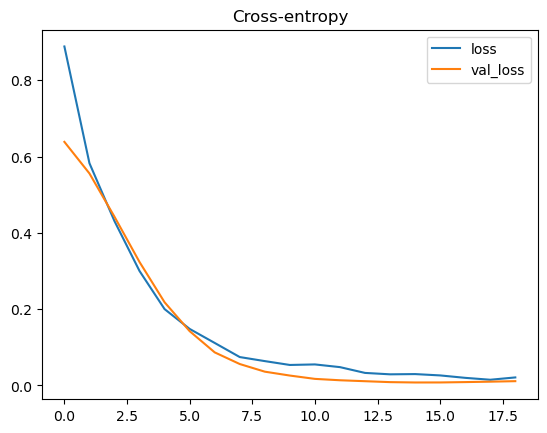

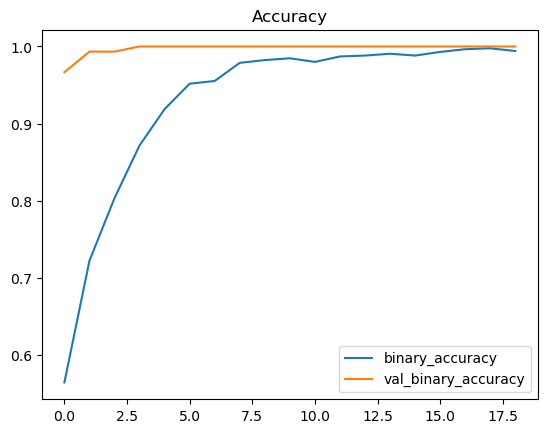

In [12]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
)
history = model.fit(
    train_df, y_train,
    validation_data=(test_df, y_test),
    batch_size=32,
    epochs=50,
    callbacks=[early_stopping],
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Accuracy")

In [13]:
from sklearn.metrics import classification_report

# Predictions on test data
y_pred = model.predict(test_df)
y_pred_classes = (y_pred > 0.5).astype("int32")

# Classification report
print(classification_report(y_test, y_pred_classes))


5/5 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

       False       1.00      1.00      1.00        81
        True       1.00      1.00      1.00        69

    accuracy                           1.00       150
   macro avg       1.00      1.00      1.00       150
weighted avg       1.00      1.00      1.00       150



<H1> PLOTS

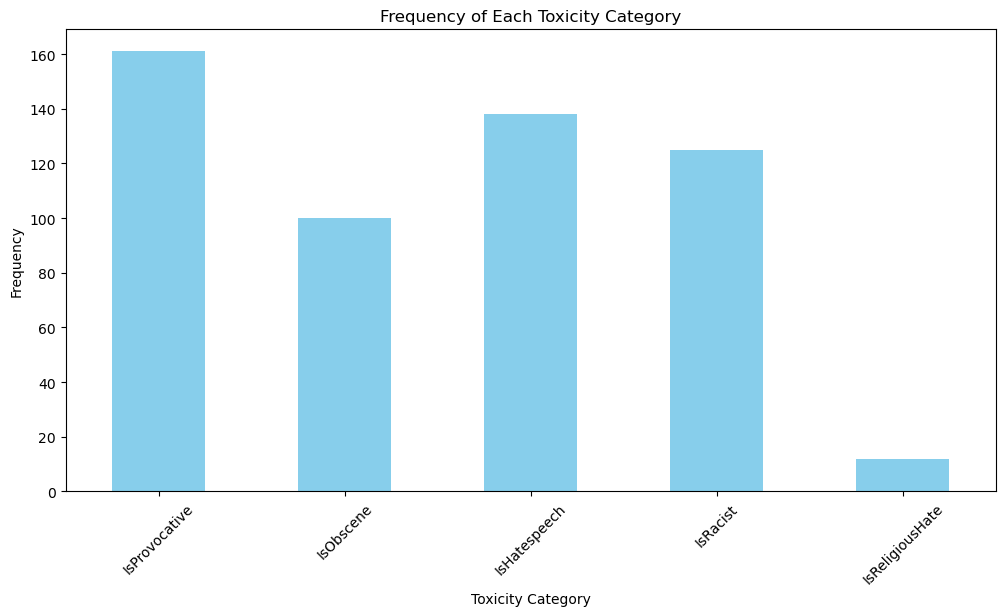

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12, 6))
toxicity_counts = data.iloc[:, 4:].sum()
toxicity_counts.plot(kind='bar', color='skyblue')
plt.title('Frequency of Each Toxicity Category')
plt.xlabel('Toxicity Category')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()


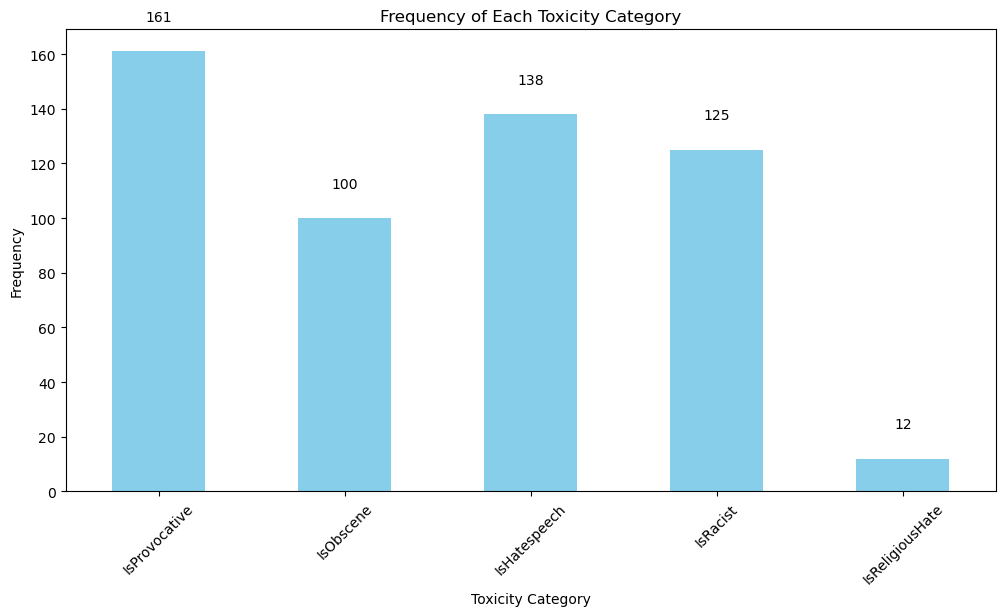

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming `data` is already defined
plt.figure(figsize=(12, 6))
toxicity_counts = data.iloc[:, 4:].sum()
toxicity_counts.plot(kind='bar', color='skyblue')
plt.title('Frequency of Each Toxicity Category')
plt.xlabel('Toxicity Category')
plt.ylabel('Frequency')
plt.xticks(rotation=45)

# Adding count on each bar
for i, v in enumerate(toxicity_counts):
    plt.text(i, v + 10, str(v), ha='center', va='bottom', fontsize=10)

plt.show()


In [16]:
import joblib

# Save the model
joblib.dump(model, 'toxic_comments_model.joblib')


['toxic_comments_model.joblib']

In [17]:


# Save the TF-IDF vectorizer
joblib.dump(vectorizer, 'tfidf_vectorizer.joblib')


['tfidf_vectorizer.joblib']